# Experiment 01

First Tests from the predictions.

In [1]:
import numpy as np
import pandas as pd
import math

import sys
sys.path.insert(1, 'C:\\Users\\Adrion\\Desktop\\TG\\DayTradeSystem\\Part1_Prediction')
import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')


def getPeriod2(df, begin, end, resetIndex = False):
    """
    Returns the df in the chosen interval
    
    Object begin: Start date forrmated as 'yyyy.mm.dd'.
    Object   end: End date 'yyyy.mm.dd'.

    returns a dataframe with the historic of the selected period
    """
    
    indexBegin = df[df['date']==begin].index[0]
    indexEnd = df[df['date']==end].tail(1).index[0]
    
    if (resetIndex):
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)].reset_index(drop=True)
    else: 
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)]

In [2]:
dfColumns = ['date','time','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

TEST_BEGIN = '2020.06.01'
TEST_END = '2021.06.01'

In [3]:
df = pd.read_csv('../Data/PETR4_M15.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df2 = pd.read_csv('../Data/VALE3_M15.csv', sep = "\t")
df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

initialDf_PETR4 = getPeriod2(df, TEST_BEGIN, TEST_END)
initialDf_VALE3 = getPeriod2(df2, TEST_BEGIN, TEST_END)

In [4]:
initialDf_PETR4

,date,time,open,high,low,close
0,2020.06.01,10:00:00,19.50,19.59,19.38,19.59
1,2020.06.01,10:15:00,19.58,19.68,19.35,19.45
2,2020.06.01,10:30:00,19.46,19.67,19.35,19.64
3,2020.06.01,10:45:00,19.64,19.73,19.49,19.52
4,2020.06.01,11:00:00,19.52,19.74,19.48,19.68
...,...,...,...,...,...,...
7311,2021.06.01,15:45:00,27.14,27.14,27.05,27.06
7312,2021.06.01,16:00:00,27.06,27.09,27.01,27.02
7313,2021.06.01,16:15:00,27.01,27.17,27.01,27.14
7314,2021.06.01,16:30:00,27.15,27.31,27.11,27.27


In [5]:
initialDf_VALE3

,date,time,open,high,low,close
0,2020.06.01,10:00:00,49.43,49.56,49.14,49.45
1,2020.06.01,10:15:00,49.43,49.78,49.42,49.57
2,2020.06.01,10:30:00,49.58,49.79,49.29,49.72
3,2020.06.01,10:45:00,49.72,50.03,49.62,49.94
4,2020.06.01,11:00:00,49.94,49.97,49.70,49.86
...,...,...,...,...,...,...
7301,2021.06.01,15:45:00,113.84,113.95,113.61,113.72
7302,2021.06.01,16:00:00,113.72,114.00,113.70,113.99
7303,2021.06.01,16:15:00,113.99,114.00,113.90,113.96
7304,2021.06.01,16:30:00,113.97,114.00,113.88,113.88


In [6]:
pred_PETR4 = pd.read_pickle('../Data/PETR4_Pred_ytd.pkl')
pred_PETR4.head(5)

,high,low,high_pred,low_pred,date
900,19.89,19.35,19.46146,18.67660,2020.06.01
901,20.70,19.93,19.45870,18.67090,2020.06.02
902,21.20,20.71,19.84014,19.04678,2020.06.03
903,21.07,20.36,19.63600,18.83430,2020.06.04
904,22.28,21.34,20.02212,19.20780,2020.06.05


In [7]:
pred_VALE3 = pd.read_pickle('../Data/VALE3_Pred_ytd.pkl')
pred_VALE3.head(15)

,high,low,high_pred,low_pred,date
900,50.40,49.14,49.55064,47.85380,2020.06.01
901,50.35,49.60,50.40516,49.45784,2020.06.02
902,50.86,49.96,50.67202,49.81672,2020.06.03
903,52.13,50.09,51.02192,50.12426,2020.06.04
904,53.07,50.86,52.27146,51.22822,2020.06.05
905,52.08,50.52,52.11760,51.02658,2020.06.08
906,51.47,50.65,52.10498,50.84252,2020.06.09
907,51.66,50.31,52.22534,50.88840,2020.06.10
908,50.59,48.65,51.95514,50.64728,2020.06.12
909,50.94,48.79,50.23170,48.97626,2020.06.15


### Início do sistema

In [8]:
def getDay(df, day):
    return df[df['date']==day]

def buy(value, availableMoney, opr='normal'):
    lotValue = value*100
    quantity = math.floor(availableMoney/lotValue)
    
    amount = quantity*lotValue
    remainingMoney = availableMoney - amount
    
    return remainingMoney, quantity

def sell(value, amount, opr='normal'):
    if(opr == 'normal'):
        return value*amount*100
    else:
        return value*amount*100

In [9]:
def runStrategy(df, dailyDf, Money, stopLoss, std):
    size = len(df.index)

    Money = Money
    stopLoss = stopLoss

    orders = []

    for day in range(0,size):
        currentDay =  df.iloc[day].date

        lowPred = df.iloc[day].low_pred*(1+std)
        highPred = df.iloc[day].high_pred*(1-std)

        dayDf = getPeriod2(dailyDf, currentDay, currentDay)
        daySize = len(dayDf.index)

        op = 'none'
        quantity = 0
        trade = []

        for i in range(0,daySize):
            currentTime = dayDf.iloc[i]

            if((op == 'buy') and (currentTime.close < opPrice*(1-stopLoss) or currentTime.close >= highPred or i == daySize-1)):
                isStop = False
                if(currentTime.close < opPrice*(1-stopLoss)): isStop = True
                aux = sell(currentTime.close, quantity)
                Money = Money + aux 
                trade = trade + [currentTime.time, 'Sell', currentTime.close, currentTime.close-opPrice,(currentTime.close-opPrice)*100*quantity, isStop, Money]
                orders.append(trade)

                quantity = 0
                op = 'none'

            elif((op == 'sell') and (currentTime.close > opPrice*(1+stopLoss) or currentTime.close <= lowPred or i == daySize-1)):
                isStop = False
                if(currentTime.close > opPrice*(1+stopLoss)): isStop = True

                aux = sell(currentTime.close, quantity)
                Money = Money + (opPrice*100*quantity) + ((opPrice*100*quantity) - aux) 
                trade = trade + [currentTime.time, 'Buy', currentTime.close, opPrice-currentTime.close,(opPrice-currentTime.close)*100*quantity, isStop, Money]
                orders.append(trade)

                quantity = 0
                op = 'none'

            elif(op == 'none' and i < daySize-1 ):
                if(currentTime.close <= lowPred):
                    Money, quantity = buy(currentTime.close, Money)
                    opPrice = currentTime.close
                    op = 'buy'

                    trade = [currentTime.date, quantity, currentTime.time, 'Buy', currentTime.close]

                elif(currentTime.close >=  highPred):
                    Money, quantity = buy(currentTime.close, Money)
                    opPrice = currentTime.close
                    op = 'sell'

                    trade = [currentTime.date, quantity, currentTime.time, 'Sell', currentTime.close]
        print('eday '+str(day)+' money: '+str(Money))
    
    ordersDf = pd.DataFrame(orders)
    ordersDf.columns = ['date','batches','time_op1','op1','value_op1','time_op2','op2','value_op2', 'profit', 'totalProfit', 'stop','Amount']
    return ordersDf

In [10]:
testPetr = runStrategy(pred_PETR4, initialDf_PETR4, 100000, 0.005, 0.01)
print('Accuracy: '+str(round(100*len(testPetr[testPetr['profit'] > 0].index)/len(testPetr.index), 2)))

testVale = runStrategy(pred_VALE3, initialDf_VALE3, 100000, 0.005, 0.01)
print('Accuracy: '+str(round(100*len(testVale[testVale['profit'] > 0].index)/len(testVale.index), 2)))

eday 0 money: 99369.0
eday 1 money: 96524.00000000003
eday 2 money: 98324.00000000003
eday 3 money: 97846.00000000001
eday 4 money: 100266.00000000003
eday 5 money: 100446.00000000003
eday 6 money: 101715.00000000003
eday 7 money: 106746.00000000003
eday 8 money: 107088.00000000001
eday 9 money: 104832.00000000003
eday 10 money: 105203.00000000003
eday 11 money: 108386.00000000001
eday 12 money: 108437.00000000003
eday 13 money: 112353.00000000003
eday 14 money: 109923.00000000001
eday 15 money: 110217.00000000001
eday 16 money: 108892.00000000006
eday 17 money: 111118.00000000006
eday 18 money: 110092.00000000006
eday 19 money: 112159.00000000006
eday 20 money: 114901.00000000004
eday 21 money: 115404.00000000003
eday 22 money: 115512.00000000004
eday 23 money: 115392.00000000006
eday 24 money: 115970.00000000007
eday 25 money: 116765.00000000007
eday 26 money: 114616.00000000007
eday 27 money: 116216.00000000006
eday 28 money: 118484.00000000007
eday 29 money: 117458.00000000007
eday

In [11]:
testPetr.tail(10)

,date,batches,time_op1,op1,value_op1,time_op2,op2,value_op2,profit,totalProfit,stop,Amount
607,2021.05.28,70,10:45:00,Sell,26.64,11:00:00,Buy,26.82,-0.18,-1260.0,True,186295.0
608,2021.05.28,69,11:15:00,Sell,26.82,14:30:00,Buy,26.97,-0.15,-1035.0,True,185260.0
609,2021.05.28,68,14:45:00,Sell,26.95,16:45:00,Buy,26.99,-0.04,-272.0,False,184988.0
610,2021.05.31,68,10:00:00,Sell,26.97,12:15:00,Buy,26.81,0.16,1088.0,False,186076.0
611,2021.05.31,69,12:30:00,Buy,26.81,16:45:00,Sell,26.87,0.06,414.0,False,186490.0
612,2021.06.01,68,10:00:00,Buy,27.37,10:15:00,Sell,27.52,0.15,1020.0,False,187510.0
613,2021.06.01,68,10:30:00,Buy,27.36,10:45:00,Sell,27.36,0.00,0.0,False,187510.0
614,2021.06.01,68,11:00:00,Sell,27.42,11:30:00,Buy,27.37,0.05,340.0,False,187850.0
615,2021.06.01,69,11:45:00,Buy,27.18,14:30:00,Sell,27.02,-0.16,-1104.0,True,186746.0
616,2021.06.01,68,14:45:00,Buy,27.10,16:45:00,Sell,27.29,0.19,1292.0,False,188038.0


In [12]:
display(testVale.loc[330:500].head(60))

,date,batches,time_op1,op1,value_op1,time_op2,op2,value_op2,profit,totalProfit,stop,Amount
330,2020.11.06,20,10:30:00,Sell,61.61,11:45:00,Buy,62.14,-0.53,-1060.0,True,127731.0
331,2020.11.06,20,12:00:00,Sell,62.08,17:45:00,Buy,61.45,0.63,1260.0,False,128991.0
332,2020.11.09,20,10:15:00,Sell,61.75,10:30:00,Buy,62.09,-0.34,-680.0,True,128311.0
333,2020.11.09,20,10:45:00,Sell,62.04,17:45:00,Buy,61.45,0.59,1180.0,False,129491.0
334,2020.11.10,20,10:00:00,Sell,61.75,17:45:00,Buy,61.42,0.33,660.0,False,130151.0
335,2020.11.11,21,10:00:00,Sell,61.31,10:15:00,Buy,61.63,-0.32,-672.0,True,129479.0
336,2020.11.11,21,10:30:00,Sell,61.59,10:45:00,Buy,62.09,-0.50,-1050.0,True,128429.0
337,2020.11.11,20,11:00:00,Sell,62.03,17:45:00,Buy,61.85,0.18,360.0,False,128789.0
338,2020.11.12,20,10:00:00,Sell,62.00,17:15:00,Buy,60.81,1.19,2380.0,False,131169.0
339,2020.11.13,21,10:00:00,Sell,61.16,11:30:00,Buy,61.60,-0.44,-924.0,True,130245.0


In [13]:
Final = testVale.tail(1).Amount
size = len(testVale)


def AnnualReturn(initial, final, days):
    return ((final/initial)**(365.25/days))-1

print(AnnualReturn(100000,Final,size))


662    0.143121
Name: Amount, dtype: float64


min 98536.0
750.0
max 99369.0
min 96524.00000000003
2844.999999999971
max 106746.00000000003
max 107088.00000000001
max 112137.00000000003
max 112353.00000000003
max 112530.00000000007
max 114859.00000000006
max 114901.00000000004
max 115512.00000000004
max 116765.00000000007
max 118484.00000000007
max 118833.00000000006
max 121304.00000000007
max 124529.00000000004
max 128203.00000000006
max 129147.00000000004
max 129247.00000000009
max 130409.0000000001
max 132020.00000000012
max 132560.00000000012
max 132740.00000000012
max 135190.00000000012
max 136450.00000000012
max 137279.00000000012
max 138126.00000000012
max 138484.00000000012
max 141014.99999999985
max 143072.99999999985
max 145939.99999999988
max 147820.99999999968
max 148558.9999999997
max 151582.99999999974
max 153788.9999999997
max 154344.99999999974
max 157148.99999999974
max 160225.9999999998
max 165921.99999999977
max 167221.9999999998
max 171441.99999999983
max 176742.99999999983
max 177655.99999999983
max 184123.9999

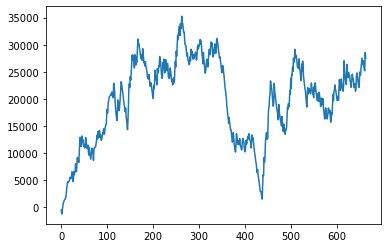

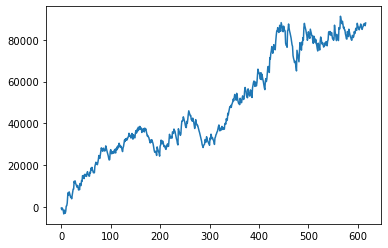

In [14]:
df = testVale
length = len(testPetr.index)

tst = df['totalProfit'].cumsum()
plt.figure();
tst.plot();

df = testPetr
tst = df['totalProfit'].cumsum()
plt.figure();
tst.plot();

lst = []

for i in range (0, length-1):
    trade = df.iloc[i]
    if (i==0):
        max = trade.Amount
        min = trade.Amount
    elif(trade.Amount > df.iloc[i-1].Amount and trade.Amount > df.iloc[i+1].Amount):
        if(trade.Amount > max):
            max = trade.Amount
            print('max ' + str(max))
        
    elif(trade.Amount < df.iloc[i-1].Amount and trade.Amount < df.iloc[i+1].Amount):
        if(trade.Amount < min):
            min = trade.Amount
            print('min ' + str(min))
            drawdown = max - min
            lst.append(drawdown)
            print(drawdown)